<a href="https://colab.research.google.com/github/dooinn/data_analysis_projects/blob/main/travel_agency_booking_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Travel Agency Booking Data

In [26]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from scipy import stats
from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
from sklearn.linear_model import LogisticRegression
import pydot



In [4]:
file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/travel.csv"
travel = pd.read_csv(file_name)

In [6]:
travel.head(5)

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


# Dataset Description of fields

- **site_name**: ID of the Expedia point of sale
- **posa_continent**: ID of continent associated with site_name
- **user_location_country**: the ID of the country the customer is located
- **user_location_region**: the ID of the region the customer is located
- **org_destination_distance**: Physical distance between a hotel and a customer at the time of search
- **user_id**: ID of user
- **is_mobile**: 1 when a user connnected from a mobile device, 0 otherwise
- **is_package**: 1 if the click/booking was generated as part of a package, 0 otherwise
- **channel**: ID of a marketing channel
- **srch_ci**: Checkin date
- **srch_co**: Checkout date
- **srch_adults_cnt**: The number of adults specified in the hotel room
- **srch_children_cnt**: The number of children specififed in the hotel room.
- **srch_rm_cnt**: The number of hotel rooms specified in the hotel room
- **srch_destination_id**: ID of the destination where the hotel search was performed
- **srch_destination_id**: ID of the destination where the hotel search was performed
-  **srch_destination_type_id**: Type of destination
- **hotel_continent**: Hotel continent
- **hotel_country**: Hotel country
- **hotel_market**: Hotel market
- **cnt**: Number of similar events in the context of the same user session
- **hotel_cluster**: ID of a hotel cluster
- **is_booking**: 1 if a boking, 0 if a click. (This is what we are predicting)

In [12]:
# summary of base info on the dataset
print("1. Rows : ", travel.shape[0])
print("2. Columns : ", travel.shape[1])
print("\n3. Features : \n", travel.columns.tolist())
print("\n4. Missing values : ", travel.isnull().sum().values.sum())
print("\n5. Unique vlaues : \n", travel.nunique())

1. Rows :  100000
2. Columns :  25

3. Features : 
 ['Unnamed: 0', 'date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']

4. Missing values :  36329

5. Unique vlaues : 
 Unnamed: 0                   100000
date_time                     99886
site_name                        41
posa_continent                    5
user_location_country           201
user_location_region            779
user_location_city            10779
orig_destination_distance     62206
user_id                       88863
is_mobile                         2
is_package                        2
channel                          11
srch_ci                        1066
srch

In [14]:
travel.describe()

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,63915.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.882530e+07,9.838570,2.678150,85.995070,308.636990,27676.391240,1960.661721,6.054383e+05,0.133770,0.248140,5.858590,2.020710,0.336750,1.111750,14426.32738,2.577290,0.079930,1.487980,3.150920,81.093290,598.848330,49.860370
std,1.086183e+07,11.996426,0.749018,59.292002,208.706581,16768.647409,2228.153377,3.516154e+05,0.340407,0.431936,3.722823,0.909774,0.734449,0.451602,11036.98122,2.149263,0.271186,1.280262,1.620534,56.111519,510.959297,28.885423
min,1.012000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.448967e+06,2.000000,3.000000,66.000000,174.000000,12949.000000,312.792100,2.987962e+05,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,8267.00000,1.000000,0.000000,1.000000,2.000000,50.000000,158.000000,25.000000
50%,1.881212e+07,2.000000,3.000000,66.000000,314.000000,27655.000000,1131.835300,6.028825e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,9145.00000,1.000000,0.000000,1.000000,2.000000,50.000000,591.000000,49.000000
75%,2.825307e+07,15.000000,3.000000,70.000000,385.000000,42328.000000,2542.359350,9.157222e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,18784.00000,5.000000,0.000000,2.000000,4.000000,106.000000,701.000000,73.000000
max,3.767009e+07,53.000000,4.000000,239.000000,1025.000000,56507.000000,11965.376100,1.198783e+06,1.000000,1.000000,10.000000,9.000000,9.000000,8.000000,65035.00000,9.000000,1.000000,120.000000,6.000000,212.000000,2117.000000,99.000000


In [17]:
# Find the where the missing values are located
travel.isnull().sum()

Unnamed: 0                       0
date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36085
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                        122
srch_co                        122
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [19]:
# Create our corelation Matrix
corr = travel.corr()
corr

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
Unnamed: 0,1.000000,0.005119,-0.000626,0.001028,0.000501,-0.002442,-0.003072,0.010300,-0.006413,-0.000838,-0.000163,-0.003140,0.000239,-0.004142,0.001031,-0.003505,-0.002716,-0.004491,0.006402,0.003373,0.004371,-0.005887
site_name,0.005119,1.000000,-0.637743,0.159283,0.130818,-0.013471,0.027609,0.030404,-0.005418,0.048820,-0.027780,-0.013405,-0.031962,0.016585,0.034895,-0.006934,-0.013460,0.022274,0.201760,0.263167,-0.068316,-0.026689
posa_continent,-0.000626,-0.637743,1.000000,0.179726,-0.034647,0.039227,0.049808,-0.015209,0.016331,-0.093459,0.089680,0.012350,0.034453,-0.033712,-0.015535,0.037172,0.013319,-0.018952,-0.333578,-0.156578,0.049214,0.018297
user_location_country,0.001028,0.159283,0.179726,1.000000,0.058496,0.122686,0.047689,-0.021091,0.003728,-0.025284,0.109999,0.042526,0.037101,0.000858,0.013486,0.028888,0.001284,0.003539,-0.063744,0.097624,0.015569,-0.011876
user_location_region,0.000501,0.130818,-0.034647,0.058496,1.000000,0.132457,0.136560,0.002225,0.016982,0.040482,-0.001600,0.005487,0.014009,0.000254,0.022567,0.001376,0.000253,-0.007570,0.043027,-0.050301,0.040367,0.004984
user_location_city,-0.002442,-0.013471,0.039227,0.122686,0.132457,1.000000,0.014178,-0.007989,-0.003741,0.013032,0.023497,0.006628,0.002638,-0.000694,0.000786,-0.004399,-0.002655,-0.002175,0.007759,-0.001987,0.008558,0.000102
orig_destination_distance,-0.003072,0.027609,0.049808,0.047689,0.136560,0.014178,1.000000,0.017015,-0.059464,0.041991,-0.000398,-0.024039,-0.059722,-0.012484,-0.036314,-0.042859,-0.033480,0.009483,0.416180,0.254321,-0.090112,0.003624
user_id,0.010300,0.030404,-0.015209,-0.021091,0.002225,-0.007989,0.017015,1.000000,-0.011439,-0.018901,-0.003593,-0.007370,0.002983,-0.001625,0.002716,0.007133,0.001561,0.001355,0.002447,0.008707,-0.002463,0.003202
is_mobile,-0.006413,-0.005418,0.016331,0.003728,0.016982,-0.003741,-0.059464,-0.011439,1.000000,0.046903,-0.030770,0.016661,0.018211,-0.022565,-0.007140,-0.016039,-0.028623,0.008084,-0.024144,-0.029574,0.007644,0.012145
is_package,-0.000838,0.048820,-0.093459,-0.025284,0.040482,0.013032,0.041991,-0.018901,0.046903,1.000000,-0.011269,-0.024097,-0.037673,-0.036653,-0.146647,-0.224422,-0.081307,0.126500,0.108993,-0.044426,-0.014636,0.031399


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

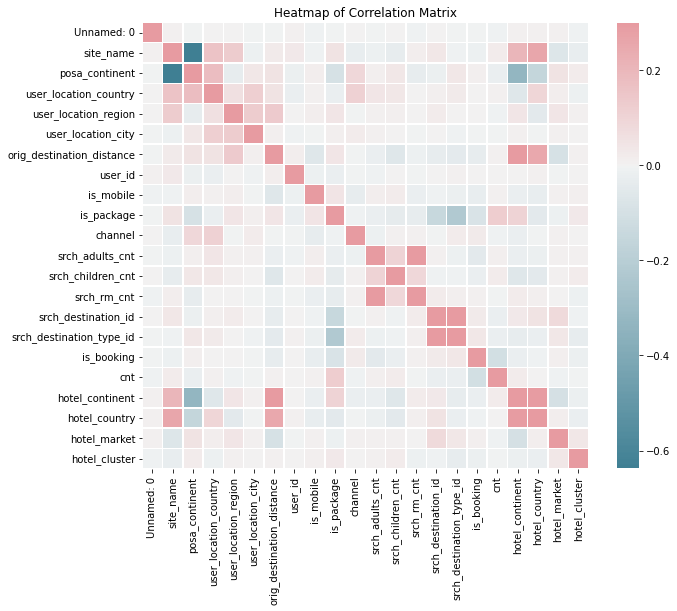

In [29]:
# Generate our corelation plot or heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4600340490>,
      dtype=object)

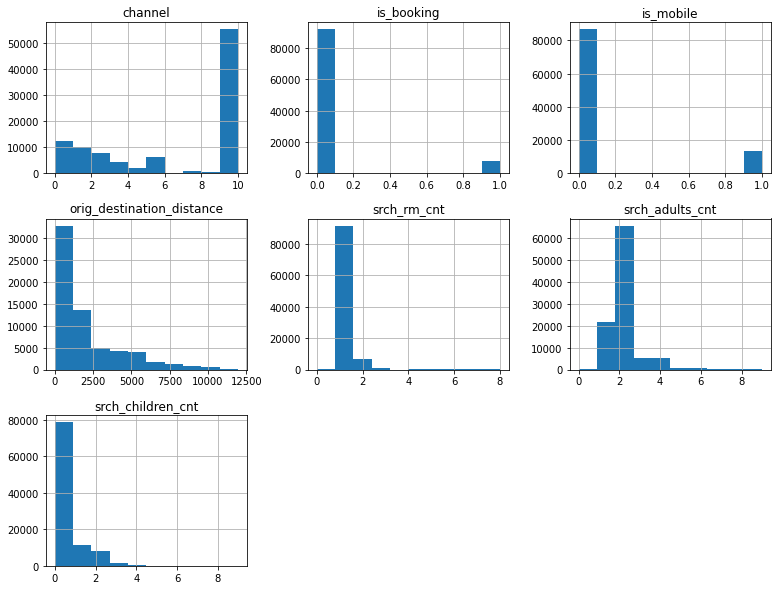

In [34]:

travel[['channel', 'is_booking', 'is_mobile', 'orig_destination_distance', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt']].hist(figsize=(13,10))